# Mesh Workflow
The intention of this notebook is to understand the workflow 
* Mesh generation in gmsh
* Mesh conversion with meshio to XDMF
* Reading mesh in dolfinx

The primary intention is to be able to mark/tag cells in gmsh with a string variable for further use in dolfinx. The tagged cells would be used to apply boundary condition, loads or material properties to different parts of the mesh.

In dolfinx we use `MeshFunction` to mark different parts of the mesh with boolean values, doubles or integers. So we need a way to transition from the string tags of gmsh to integers in dolfinx. For this we can use dictionaries or some class.

# Step 1: Mesh generation in gmsh
This step is simulated here with the help of pygmsh. Pygmsh combines the power of Gmsh with the versatility of Python to provide useful abstractions from the Gmsh scripting language. In short we can make the `.geo` from pygmsh. In real world scenario user would normally use gmsh to create the `.geo` file. 

In [2]:
from pygmsh.built_in.geometry import Geometry

In [3]:
geom = Geometry()

In [4]:
mesh_ele_size = .25
p0 = geom.add_point([0, 0, 0], lcar=mesh_ele_size)
p1 = geom.add_point([1, 0, 0], lcar=mesh_ele_size)
p2 = geom.add_point([1, 1, 0], lcar=mesh_ele_size)
p3 = geom.add_point([0, 1, 0], lcar=mesh_ele_size)

l0 = geom.add_line(p0, p1)
l1 = geom.add_line(p1, p2)
l2 = geom.add_line(p2, p3)
l3 = geom.add_line(p3, p0)

ll = geom.add_line_loop(lines=[l0, l1, l2, l3])
ps = geom.add_plane_surface(ll)

In [5]:
# Tag line and surface
geom.add_physical(l3, label=444)
geom.add_physical(ps, label=456)

`geom._GMSH_CODE` gives us the script created by pygmsh that would be normally created in gmsh.

In [6]:
print("\n".join(geom._GMSH_CODE))

// This code was created by pygmsh v5.0.1.
p0 = newp;
Point(p0) = {0, 0, 0, 0.25};
p1 = newp;
Point(p1) = {1, 0, 0, 0.25};
p2 = newp;
Point(p2) = {1, 1, 0, 0.25};
p3 = newp;
Point(p3) = {0, 1, 0, 0.25};
l0 = newl;
Line(l0) = {p0, p1};
l1 = newl;
Line(l1) = {p1, p2};
l2 = newl;
Line(l2) = {p2, p3};
l3 = newl;
Line(l3) = {p3, p0};
ll0 = newll;
Line Loop(ll0) = {l0, l1, l2, l3};
s0 = news;
Plane Surface(s0) = {ll0};
Physical Line(444) = {l3};
Physical Surface(456) = {s0};


### Generation of mesh object
In gmsh the user creates a `.msh` mesh file. Here we are creating a mesh object directly that could be used in meshio. Without this we had to do the following

`mesh = meshio.read(filename.msh)
points, cells, cell_data = mesh.points, mesh.cells, mesh.cell_data`

In [7]:
from pygmsh import generate_mesh
mesh = generate_mesh(geom)

Info    : Running 'gmsh -3 /tmp/tmp5iysiz72.geo -format msh -bin -o /tmp/tmp5q_ya_9j.msh' [Gmsh 4.2.2, 1 node, max. 1 thread]
Info    : Started on Fri Jun 21 00:33:55 2019
Info    : Reading '/tmp/tmp5iysiz72.geo'...
Info    : Done reading '/tmp/tmp5iysiz72.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 2 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Done meshing 1D (0 s)
Info    : Meshing 2D...
Info    : Meshing surface 6 (Plane, Delaunay)
Info    : Done meshing 2D (0 s)
Info    : Meshing 3D...
Info    : Done meshing 3D (0 s)
Info    : 29 vertices 60 elements
Info    : Writing '/tmp/tmp5q_ya_9j.msh'...
Info    : Done writing '/tmp/tmp5q_ya_9j.msh'
Info    : Stopped on Fri Jun 21 00:33:55 2019


# Step 2: Mesh conversion with meshio to XDMF

In [8]:
import meshio

meshio reads the mesh file into a `Mesh` object and then converts that mesh object into the specified format. Since we have already created the mesh object we can use it.

In [9]:
points, cells, cell_data = mesh.points, mesh.cells, mesh.cell_data

### Creating the actual mesh of triangles

In [10]:
meshio.write("mesh_2d.xdmf", meshio.Mesh(
    points=points,
    cells={"triangle": cells["triangle"]}))

### Creating a XDMF file of tagged boundary to be read by MeshValueCollection

In [11]:
meshio.write("mvc_1d.xdmf", meshio.Mesh(
    points=points,
    cells={"line": cells["line"]},
    cell_data={"line": {"name_to_read": cell_data["line"]["gmsh:physical"]}}
))

# Step 3: Reading mesh in dolfinx

In [12]:
import dolfin
import dolfin.io

In [13]:
with dolfin.io.XDMFFile(dolfin.MPI.comm_world,"mesh_2d.xdmf") as xdmf_infile:
    mesh_2d = xdmf_infile.read_mesh(dolfin.MPI.comm_world, dolfin.cpp.mesh.GhostMode.none)

In [14]:
import dolfin.plotting as plt
%matplotlib inline

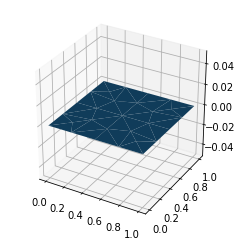

In [15]:
plt.plot(mesh_2d)

# MeshValueCollection
The MeshValueCollection class can be used to store data associated with a subset of the entities of a mesh of a given topological dimension. It differs from the MeshFunction class in two ways. First, data does not need to be associated with all entities (only a subset). Second, data is associated with entities through the corresponding cell index and local entity number (relative to the cell), not by global entity index, which means that data may be stored robustly to file.

In [16]:
mvc = dolfin.MeshValueCollection("size_t", mesh_2d, 1)

Reading 1d line data into dolfin mvc

In [17]:
with dolfin.io.XDMFFile(dolfin.MPI.comm_world,"mvc_1d.xdmf") as xdmf_infile:
    mvc = xdmf_infile.read_mvc_size_t(mesh_2d,"name_to_read")

In [18]:
mvc.values()

{(9, 2): 444, (13, 2): 444, (33, 2): 444, (36, 2): 444}

In [19]:
print("Constructing MeshFunction from MeshValueCollection")
mf = dolfin.cpp.mesh.MeshFunctionSizet(mesh_2d, mvc, 1)

Constructing MeshFunction from MeshValueCollection


In [20]:
mf.array()

array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1, 444,   1, 444,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1, 444,   1, 444,   1,
         1,   1,   1], dtype=uint64)

In [23]:
cells

{'line': array([[ 3, 13],
        [13, 14],
        [14, 15],
        [15,  0]]), 'triangle': array([[17, 10, 21],
        [18, 13, 22],
        [19,  7, 23],
        [20,  4, 24],
        [ 9, 17, 23],
        [ 6, 19, 24],
        [12, 18, 21],
        [15, 20, 22],
        [10, 11, 21],
        [13, 14, 22],
        [ 7,  8, 23],
        [ 4,  5, 24],
        [11, 12, 21],
        [14, 15, 22],
        [ 8,  9, 23],
        [ 5,  6, 24],
        [16, 17, 21],
        [18, 16, 21],
        [16, 18, 22],
        [17, 16, 23],
        [20, 16, 22],
        [16, 19, 23],
        [19, 16, 24],
        [16, 20, 24],
        [10, 17, 25],
        [13, 18, 26],
        [ 7, 19, 27],
        [ 4, 20, 28],
        [17,  9, 25],
        [19,  6, 27],
        [18, 12, 26],
        [20, 15, 28],
        [ 2, 10, 25],
        [ 3, 13, 26],
        [12,  3, 26],
        [ 9,  2, 25],
        [15,  0, 28],
        [ 6,  1, 27],
        [ 1,  7, 27],
        [ 0,  4, 28]])}

In [29]:
mesh_from_array = dolfin.cpp.mesh.Mesh(
    dolfin.MPI.comm_world, 
    dolfin.cpp.mesh.CellType.Type.triangle, 
    points,
    cells['triangle'], 
    [], 
    dolfin.cpp.mesh.GhostMode.none)

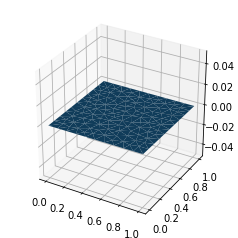

In [31]:
plt.plot(mesh_from_array)

In [33]:
mvc = dolfin.MeshValueCollection("size_t", mesh_from_array, 1)

In [40]:
mvc.set_value(6,1)

True

In [41]:
mvc.values()

{(0, 1): 1, (4, 1): 1}

In [43]:
cells

{'line': array([[ 3, 31],
        [31, 32],
        [32, 33],
        [33, 34],
        [34, 35],
        [35, 36],
        [36, 37],
        [37, 38],
        [38, 39],
        [39,  0]]), 'triangle': array([[  1,  13,  53],
        [  0,   4,  72],
        [  2,  22,  98],
        [  3,  31,  51],
        [ 12,   1,  53],
        [ 39,   0,  72],
        [ 21,   2,  98],
        [ 30,   3,  51],
        [113,  74,  46],
        [ 77,  74, 113],
        [ 75,  63,  62],
        [ 75,  54,  63],
        [ 76,  45,  62],
        [ 76,  62, 141],
        [ 65,  91, 110],
        [ 64,  90, 109],
        [ 70,  93, 112],
        [ 68,  92, 111],
        [ 91,  41, 110],
        [ 90,  42, 109],
        [ 93,  48, 112],
        [ 92,  43, 111],
        [ 77,  52,  94],
        [ 54,  56,  95],
        [ 49,  55,  96],
        [ 45,  57,  97],
        [ 95,  67, 103],
        [ 94,  66, 104],
        [ 97,  71, 106],
        [ 96,  69, 107],
        [ 49,  76, 141],
        [ 26,  27,  47],

In [22]:
points

array([[ 0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ],
       [ 1.        ,  1.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.25      ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ],
       [ 0.75      ,  0.        ,  0.        ],
       [ 1.        ,  0.25      ,  0.        ],
       [ 1.        ,  0.5       ,  0.        ],
       [ 1.        ,  0.75      ,  0.        ],
       [ 0.75      ,  1.        ,  0.        ],
       [ 0.5       ,  1.        ,  0.        ],
       [ 0.25      ,  1.        ,  0.        ],
       [ 0.        ,  0.75      ,  0.        ],
       [ 0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.25      ,  0.        ],
       [ 0.5       ,  0.5       ,  0.        ],
       [ 0.70833333,  0.70833333,  0.        ],
       [ 0.29166667,  0.70833333,  0.        ],
       [ 0.70833333,  0.29166667,  0.        ],
       [ 0.29166667,  0.29166667,  0.   